In [1]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, det_curve
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import defaultdict
import numpy as np

import sys
import time
repo_root = "../../"
sys.path.append(repo_root)
from models import CompositeClassifier
from utils.functions import fix_random_seed
fix_random_seed()

x_train = np.load("X-1647041985-early-fusion-vectors-train.arr")
y_train = np.load("y-1647041985-train.arr")

X_val = np.load("X-1647097165-early-fusion-vectors-val.arr")
y_val = np.load("y-1647097165-val.arr")

def fit(models, x_trains, y_train, save=False):
    for model in models:
        
        print(f"Fitting model: {model}", end=" | ")
        c1 = time.time()
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_late_fusion_model()
        print(f"Took: {time.time() - c1:.2f}s")

def evaluate(models, X_vals, y_val, ax=None, threshold=0.6, print_score=True):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(X_vals[model])[:,1]
        preds = np.where(probs[model] > threshold, 1, 0)
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y_val, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y_val, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y_val.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y_val))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = roc_curve(y_val, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    _ = ax.legend()
    return probs

/home/dmitrijs.trizna/.pyenv/versions/3.8-dev/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Different late fusion networks

In [2]:
models = {}
modules = ["malconv", "ember", "filepaths", "emulation"]

params = {
"malconv_model_path": 'modules/sota/malconv/parameters/malconv.checkpoint',
"ember_2019_model_path": 'modules/sota/ember/parameters/ember_model.txt',
"filepath_model_path": 'modules/filepath/pretrained/torch.model',
"filepath_bytes": 'modules/filepath/pretrained/pickle.bytes',
"emulation_model_path": 'modules/emulation/pretrained/torch.model',
"emulation_apicalls": 'modules/emulation/pretrained/pickle.apicalls',
}

models["Logistic Regression"] = CompositeClassifier(modules=modules, late_fusion_model="LogisticRegression", **params, root=repo_root)
models["XGBClassifier"] = CompositeClassifier(modules=modules, late_fusion_model="XGBClassifier",**params, root=repo_root)
models["MultiLayerPerceptron15"] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron",**params, root=repo_root, mlp_hidden_layer_sizes=(15,))
models["MultiLayerPerceptron50"] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron",**params, root=repo_root, mlp_hidden_layer_sizes=(50,))
models["MultiLayerPerceptron100"] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron",**params, root=repo_root, mlp_hidden_layer_sizes=(100,))

x_trains = dict([(model, x_train) for model in models])
X_vals = dict([(model, X_val) for model in models])

In [3]:
fit(models, x_trains, y_train)

Fitting model: Logistic Regression | Took: 0.19s
Fitting model: XGBClassifier | Took: 7.24s
Fitting model: MultiLayerPerceptron15 | Took: 3.05s
Fitting model: MultiLayerPerceptron50 | Took: 8.20s
Fitting model: MultiLayerPerceptron100 | Took: 10.41s



 ====== Logistic Regression ======
ROC AUC score: 0.9987736442550271
Classification report:
              precision    recall  f1-score   support

         0.0     0.9718    0.9625    0.9671      4982
         1.0     0.9859    0.9895    0.9877     13190

    accuracy                         0.9821     18172
   macro avg     0.9789    0.9760    0.9774     18172
weighted avg     0.9820    0.9821    0.9820     18172


 ====== XGBClassifier ======
ROC AUC score: 0.9990002218753243
Classification report:
              precision    recall  f1-score   support

         0.0     0.9755    0.9659    0.9707      4982
         1.0     0.9872    0.9908    0.9890     13190

    accuracy                         0.9840     18172
   macro avg     0.9813    0.9784    0.9798     18172
weighted avg     0.9840    0.9840    0.9840     18172


 ====== MultiLayerPerceptron15 ======
ROC AUC score: 0.9987725637921993
Classification report:
              precision    recall  f1-score   support

         0.0   

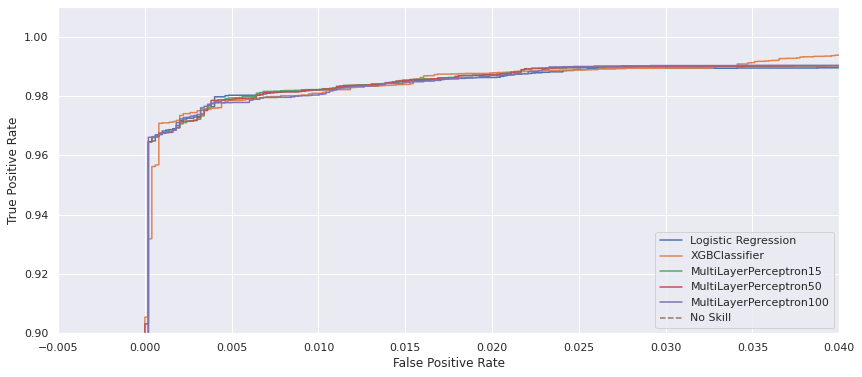

In [6]:
pp = evaluate(models, X_vals, y_val)
plt.xlim([-0.005, 0.04])
plt.ylim([0.9, 1.01])
plt.legend(loc="lower right")

## Different modules

In [8]:
# modulelist = [["malconv"], ["ember"], ["filepaths"], ["emulation"], 
#             ["ember", "emulation"], ["malconv", "ember", "emulation"], 
#             ["ember", "emulation", "filepaths"],
#             ["malconv", "ember", "filepaths", "emulation"]]

modulelist = [["ember"], ["filepaths"], ["emulation"], ["emulation", "filepaths"],
            ["ember", "emulation"], ["ember", "filepaths"],
            ["ember", "emulation", "filepaths"]]

models = {}
x_trains = {}
X_vals = {}
for modules in modulelist:
    name = " & ".join(modules)
    if len(modules) == 4:
        name = "All"
    params = {
        "malconv_model_path": 'modules/sota/malconv/parameters/malconv.checkpoint',
        "ember_2019_model_path": 'modules/sota/ember/parameters/ember_model.txt',
        "filepath_model_path": 'modules/filepath/pretrained/torch.model',
        "filepath_bytes": 'modules/filepath/pretrained/pickle.bytes',
        "emulation_model_path": 'modules/emulation/pretrained/torch.model',
        "emulation_apicalls": 'modules/emulation/pretrained/pickle.apicalls',
    }
    models[name] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron", mlp_hidden_layer_sizes=(15,), **params, root=repo_root)
    x_trains[name] = models[name].get_modular_x(modules, x_train)
    X_vals[name] = models[name].get_modular_x(modules, X_val)

In [9]:
fit(models, x_trains, y_train)

Fitting model: ember | Took: 8.43s
Fitting model: filepaths | Took: 5.57s
Fitting model: emulation | Took: 4.68s
Fitting model: emulation & filepaths | Took: 6.87s
Fitting model: ember & emulation | Took: 30.10s
Fitting model: ember & filepaths | Took: 4.89s
Fitting model: ember & emulation & filepaths | Took: 5.08s


In [10]:
def get_threshold_from_rate(thresholds, rate_array, rate):
    index = np.where(rate_array >= rate)[0][0]
    return thresholds[index]

def get_value_from_threshold(values, thresholds, threshold):
    thr_index = np.where(thresholds <= threshold)[0][0]
    return values[thr_index]

probs = {}
for model in models:
    probs[model] = models[model].predict_proba(X_vals[model])[:,1]

fprs = {}
fnrs = {}
tprs = {}
thresholds_roc = {}
thresholds_det = {}

for model in probs:
    fprs[model], tprs[model], thresholds_roc[model] = roc_curve(y_val, probs[model])
    _, fnrs[model], thresholds_det[model] = det_curve(y_val, probs[model])

In [11]:
# df = pd.DataFrame()
fixed_fpr_rates = defaultdict(list)
for fpr_rate in list(np.arange(0.00025, 0.0031, 0.00025)):
    print("===" * 10)
    for model in models:
        threshold = get_threshold_from_rate(thresholds_roc[model], fprs[model], fpr_rate)
        tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
        fnr_rate = get_value_from_threshold(fnrs[model], thresholds_det[model][::-1], threshold)
        fixed_fpr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold]) 
        # ldf = pd.DataFrame({"fpr_rate":fpr_rate, "tpr_rate": tpr_rate, "fnr_rate": fnr_rate, "threshold": threshold}, index=[model])
        # df = pd.concat([df,ldf])
        print(f"FPR: {fpr_rate*100:>5.3f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

FPR: 0.025% | TPR: 14.14% | FNR:  0.02% | Thr.: 0.9952 | ember
FPR: 0.025% | TPR:  4.23% | FNR:  0.02% | Thr.: 0.9987 | filepaths
FPR: 0.025% | TPR: 27.76% | FNR:  0.06% | Thr.: 0.9956 | emulation
FPR: 0.025% | TPR: 69.11% | FNR:  0.01% | Thr.: 0.9998 | emulation & filepaths
FPR: 0.025% | TPR: 83.33% | FNR:  0.03% | Thr.: 0.9987 | ember & emulation
FPR: 0.025% | TPR: 85.38% | FNR:  0.01% | Thr.: 1.0000 | ember & filepaths
FPR: 0.025% | TPR: 96.37% | FNR:  0.02% | Thr.: 0.9994 | ember & emulation & filepaths
FPR: 0.050% | TPR: 18.04% | FNR:  0.22% | Thr.: 0.9952 | ember
FPR: 0.050% | TPR: 15.66% | FNR:  0.06% | Thr.: 0.9987 | filepaths
FPR: 0.050% | TPR: 37.20% | FNR:  0.06% | Thr.: 0.9956 | emulation
FPR: 0.050% | TPR: 86.47% | FNR:  0.01% | Thr.: 0.9998 | emulation & filepaths
FPR: 0.050% | TPR: 83.41% | FNR:  0.03% | Thr.: 0.9987 | ember & emulation
FPR: 0.050% | TPR: 87.02% | FNR:  0.01% | Thr.: 1.0000 | ember & filepaths
FPR: 0.050% | TPR: 96.54% | FNR:  0.02% | Thr.: 0.9993 | embe

In [12]:
fixed_fnr_rates = defaultdict(list)
for fnr_rate in [0.0005, 0.001] + list(np.arange(0.0025, 0.02, 0.0025)):
    print("===" * 10)
    for model in models:
        threshold = get_threshold_from_rate(thresholds_det[model], fnrs[model], fnr_rate)
        tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
        fpr_rate = get_value_from_threshold(fprs[model], thresholds_roc[model], threshold)
        fixed_fnr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold])
        print(f"FPR: {fpr_rate*100:>5.2f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

FPR: 70.19% | TPR: 99.79% | FNR:  0.05% | Thr.: 0.0957 | ember
FPR: 90.45% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0001 | filepaths
FPR: 54.34% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0032 | emulation
FPR: 43.90% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0000 | emulation & filepaths
FPR: 28.36% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0004 | ember & emulation
FPR: 51.59% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0000 | ember & filepaths
FPR: 26.62% | TPR: 99.95% | FNR:  0.05% | Thr.: 0.0001 | ember & emulation & filepaths
FPR: 70.19% | TPR: 99.79% | FNR:  0.10% | Thr.: 0.0957 | ember
FPR: 73.67% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0001 | filepaths
FPR: 33.26% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0034 | emulation
FPR: 17.24% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0005 | emulation & filepaths
FPR: 19.69% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0052 | ember & emulation
FPR: 33.62% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0000 | ember & filepaths
FPR: 14.43% | TPR: 99.89% | FNR:  0.10% | Thr.: 0.0005 | embe

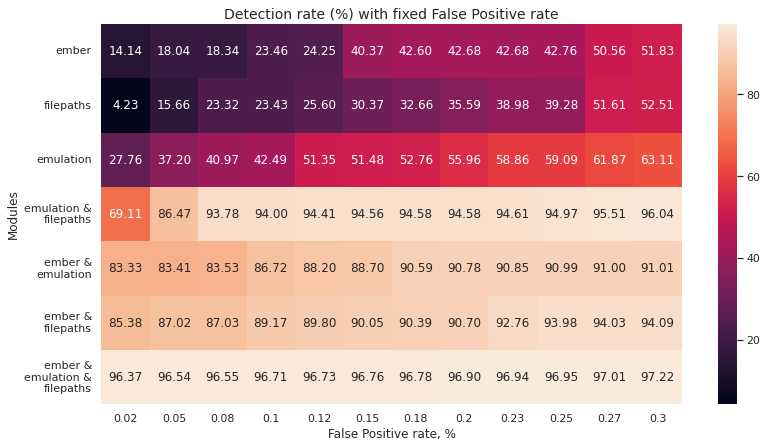

In [13]:
# keys for y label
keys = models.keys()

# rates for x label
fpr_rates = [np.array(fixed_fpr_rates[key])[:,0] for key in fixed_fpr_rates][0]
fpr_rates = [np.round(x*100, 2) for x in fpr_rates]

# rearrange rows, so "all" is last
tpr_rates = np.vstack([np.array(fixed_fpr_rates[key])[:,1] for key in fixed_fpr_rates])
tpr_rates = np.round(tpr_rates*100,2)

fig, ax = plt.subplots(figsize=(13,7))
ax = sns.heatmap(tpr_rates, ax = ax,
            annot=True, fmt=".2f",
            xticklabels=fpr_rates,
            yticklabels=[x.replace(" & ", " &\n") for x in keys])

ax.set_xlabel("False Positive rate, %", fontsize=12)
ax.set_ylabel("Modules", fontsize=12)
_ = ax.set_title("Detection rate (%) with fixed False Positive rate", fontsize=14)

fig.savefig("/data/quo.vadis/img/rate_heatmap.eps",  format='eps', dpi=600, bbox_inches='tight')


 ====== malconv ======
ROC AUC score: 0.690591268825543
Classification report:
              precision    recall  f1-score   support

         0.0     0.6225    0.3280    0.4296      4982
         1.0     0.7847    0.9249    0.8490     13190

    accuracy                         0.7612     18172
   macro avg     0.7036    0.6264    0.6393     18172
weighted avg     0.7402    0.7612    0.7340     18172


 ====== ember ======
ROC AUC score: 0.9860326135421863
Classification report:
              precision    recall  f1-score   support

         0.0     0.8914    0.9785    0.9329      4982
         1.0     0.9916    0.9550    0.9729     13190

    accuracy                         0.9614     18172
   macro avg     0.9415    0.9667    0.9529     18172
weighted avg     0.9641    0.9614    0.9620     18172


 ====== filepaths ======
ROC AUC score: 0.9885937365417702
Classification report:
              precision    recall  f1-score   support

         0.0     0.9502    0.9301    0.9401      

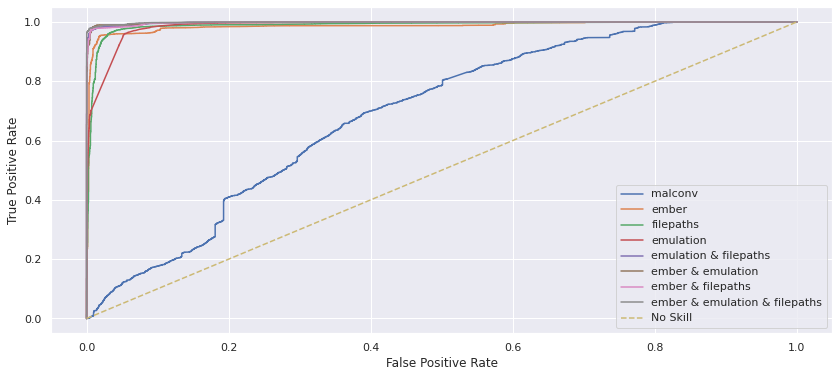

In [6]:
probs = evaluate(models, X_vals, y_val)

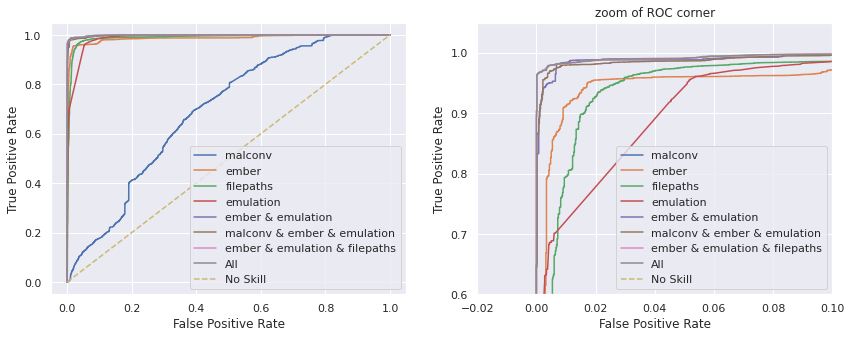

In [86]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
evaluate(models, X_vals, y_val, ax=ax[0], print_score=False)
probs = evaluate(models, X_vals, y_val, ax=ax[1], print_score=False)
ax[1].set_ylim([0.6, 1.05])
ax[1].set_xlim([-0.02, 0.1])
_ = ax[1].set_title("zoom of ROC corner")
#ax[1].legend(legend)
#_ = ax[0].legend(legend)

### Confusion matrix 

In [4]:
def draw_confusion_matrix(y_true, y_pred, counts=False, figsize=(6,6)):
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    groups = ["True Negative","False Positive","False Negative","True Positive"]

    if counts:
        labels = [f"{y}\n{x}\n{z}" for x,y,z in zip(group_percentages, groups, group_counts)]
    else:
        labels = [f"{y}\n{x}" for x,y in zip(group_percentages, groups)]
    labels = np.asarray(labels).reshape(2,2)

    f, ax = plt.subplots(1,1, figsize=figsize)
    ax = sns.heatmap(cf_matrix, annot=labels, ax=ax,
                fmt='', cbar=False, cmap='Blues',
                xticklabels=["benign", "malicious"],
                yticklabels=["benign", "malicious"])
    ax.set_ylabel("Ground truth label")
    ax.set_xlabel("Prediction")

def print_scores(y_true, y_pred):
    print("F1: ",f1_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("Accuracy: ", (y_true == y_pred).mean() * 100)

F1:  0.8584994612068966
Recall:  0.9664139499620925
Precision:  0.772264631043257
Accuracy:  76.87651331719128


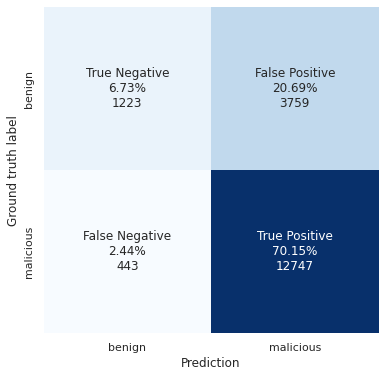

In [7]:
y_pred = (probs["malconv"] >= 0.5).astype(int)
draw_confusion_matrix(y_val, y_pred, counts=True)
print_scores(y_val, y_pred)

F1:  0.9715347972580457
Recall:  0.9509476876421531
Precision:  0.9930330140131423
Accuracy:  95.95531587057012


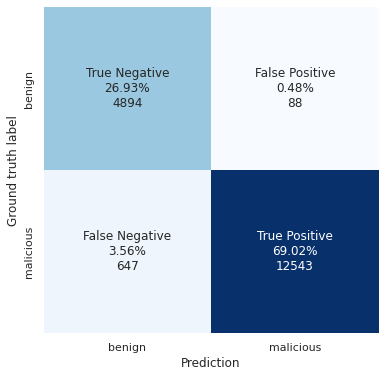

In [8]:
y_pred = (probs["ember"] >= 0.8336).astype(int)
draw_confusion_matrix(y_val, y_pred, counts=True)
print_scores(y_val, y_pred)

Threshold == 0.6:

F1:  0.9900425661295225
Recall:  0.9874905231235784
Precision:  0.9926078341716201
Accuracy:  98.55822143957738


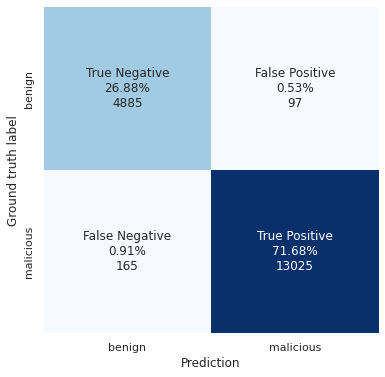

In [16]:
y_pred = (probs["All"] >= 0.6).astype(int)
draw_confusion_matrix(y_val, y_pred, counts=True)
print_scores(y_val, y_pred)

F1:  0.9900523957779633
Recall:  0.9884761182714178
Precision:  0.9916337085488287
Accuracy:  98.55822143957738


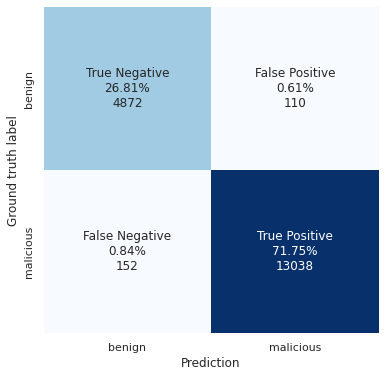

In [17]:
y_pred = (probs["ember & emulation & filepaths"] >= 0.6).astype(int)
draw_confusion_matrix(y_val, y_pred, counts=True)
print_scores(y_val, y_pred)

Threshold: 0.9990 represents FP rate of 0.05 %

F1:  0.9900425661295225
Recall:  0.9874905231235784
Precision:  0.9926078341716201
Accuracy:  98.55822143957738


0.984010215395591

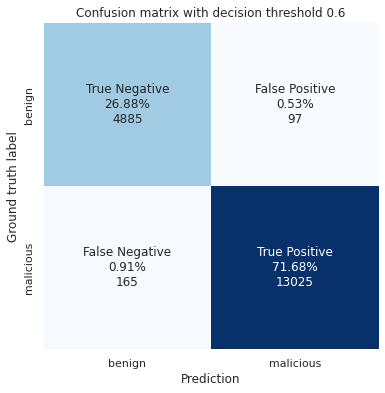

In [89]:
threshold = 0.6
y_pred = (probs["All"] >= threshold).astype(int)
draw_confusion_matrix(y_val, y_pred, counts=True)
plt.title(f"Confusion matrix with decision threshold {threshold}")
print_scores(y_val, y_pred)
roc_auc_score(y_val, y_pred)

In [88]:
x_train_prob = models["All"].predict_proba(x_trains["All"])[:,1]
y_train_preds = np.where(x_train_prob > 0.6, 1, 0)
print_scores(y_train, y_train_preds)
roc_auc_score(y_train, y_train_preds)

F1:  0.9994844081196174
Recall:  0.9993317422434368
Precision:  0.9996371206478352
Accuracy:  99.92570579494799


0.9991980982131556

### DET curves

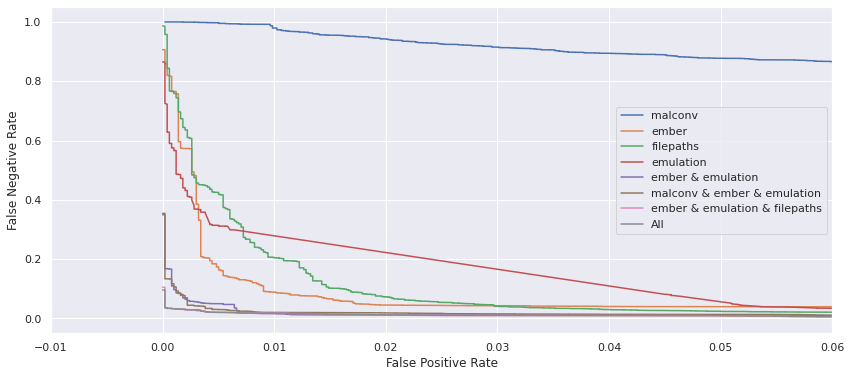

In [5]:
def plot_det_curve(models, X_vals, y_val, ax=None, print_score=True):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(X_vals[model])[:,1]
        preds = np.where(probs[model] > 0.5, 1, 0)
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y_val, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y_val, preds, digits=4))

    # model = "No Skill"
    # most_common_label = np.argmax(np.bincount(y_val.astype(int)))
    # probs[model] = np.array([most_common_label for _ in range(len(y_val))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = det_curve(y_val, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('False Negative Rate')
    _ = ax.legend()
    return probs

pp = plot_det_curve(models, X_vals, y_val, print_score=False)
_ = plt.xlim([-0.01, 0.06])

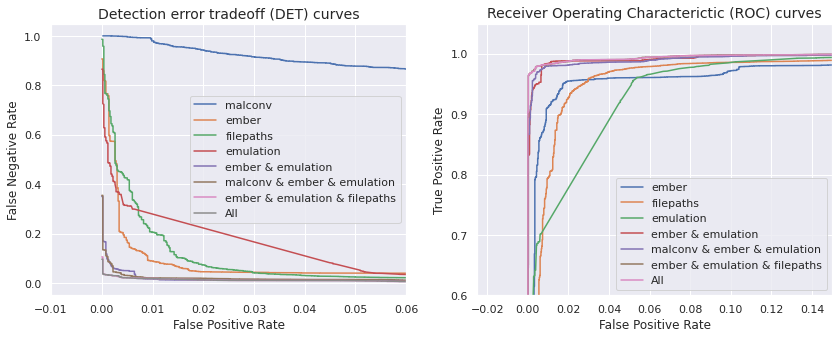

In [13]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
probs = evaluate(models, X_vals, y_val, ax=ax[1], print_score=False)
ax[1].set_ylim([0.6, 1.05])
ax[1].set_xlim([-0.025, 0.15])
ax[1].set_title("Receiver Operating Characterictic (ROC) curves", fontsize=14)
#ax[1].legend(legend)

pp = plot_det_curve(models, X_vals, y_val, ax=ax[0], print_score=False)
ax[0].set_xlim([-0.01, 0.06])
ax[0].legend(loc="best")
_ = ax[0].set_title("Detection error tradeoff (DET) curves", fontsize=14)
#_ = ax[0].legend(legend)

### Heatmaps

```
fixed_fpr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold]) 
fixed_fnr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold])
```

### FP rates

In [36]:
# keys for y label
keys = models.keys()

# rates for x label
fpr_rates = [np.array(fixed_fpr_rates[key])[:,0] for key in fixed_fpr_rates][0]
fpr_rates = [np.round(x*100, 2) for x in fpr_rates]

# rearrange rows, so "all" is last
tpr_rates = np.vstack([np.array(fixed_fpr_rates[key])[:,1] for key in fixed_fpr_rates])
tpr_rates = np.round(tpr_rates*100,2)

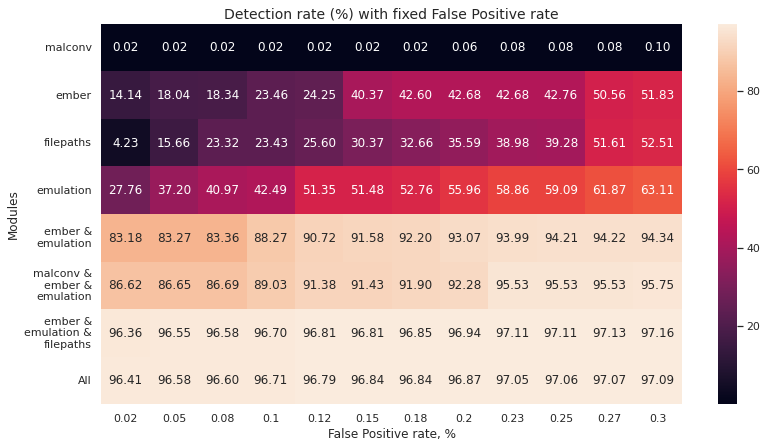

In [54]:
fig, ax = plt.subplots(figsize=(13,7))
ax = sns.heatmap(tpr_rates, ax = ax,
            annot=True, fmt=".2f",
            xticklabels=fpr_rates,
            yticklabels=[x.replace(" & ", " &\n") for x in keys])

ax.set_xlabel("False Positive rate, %", fontsize=12)
ax.set_ylabel("Modules", fontsize=12)
_ = ax.set_title("Detection rate (%) with fixed False Positive rate", fontsize=14)

### FN rates

In [45]:
# keys for y label
keys = models.keys()

# rates for x label
fnr_rates = [np.array(fixed_fnr_rates[key])[:,2] for key in fixed_fnr_rates][0]
fnr_rates = [np.round(x*100, 2) for x in fnr_rates]

# rearrange rows, so "all" is last
tpr_rates_fn = np.vstack([np.array(fixed_fnr_rates[key])[:,0] for key in fixed_fnr_rates])
tpr_rates_fn = np.round(tpr_rates_fn*100,2) 

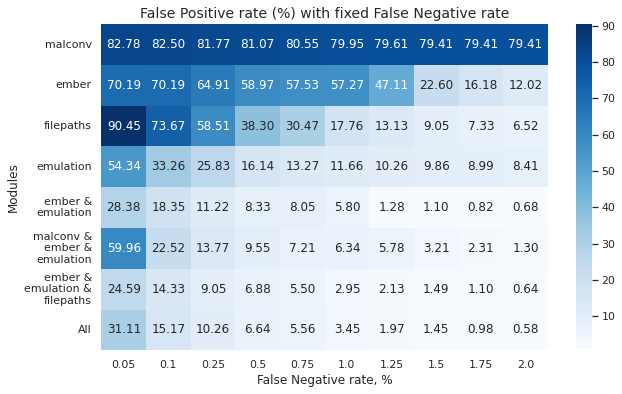

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(tpr_rates_fn, ax = ax,
            annot=True, fmt=".2f",
            xticklabels=fnr_rates,
            yticklabels=[x.replace(" & ", " &\n") for x in keys],
            cmap="Blues")

ax.set_xlabel("False Negative rate, %", fontsize=12)
ax.set_ylabel("Modules", fontsize=12)
_ = ax.set_title("False Positive rate (%) with fixed False Negative rate", fontsize=14)

### Joining

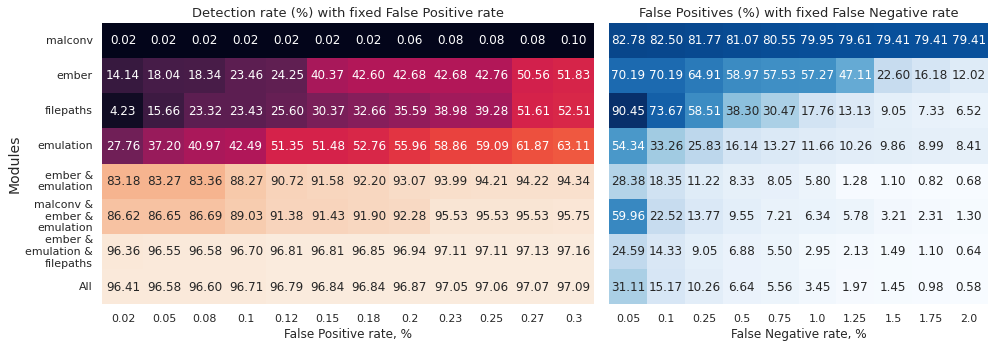

In [48]:
fig, ax = plt.subplots(1,2, figsize=(14,5), gridspec_kw={'width_ratios': [len(fpr_rates)+1, len(fnr_rates)]})

_ = sns.heatmap(tpr_rates, ax = ax[0],
            annot=True, fmt=".2f",
            xticklabels=fpr_rates,
            yticklabels=[x.replace(" & ", " &\n") for x in keys], cbar=False)

ax[0].set_xlabel("False Positive rate, %", fontsize=12)
ax[0].set_ylabel("Modules", fontsize=14)
_ = ax[0].set_title("Detection rate (%) with fixed False Positive rate", fontsize=13)

_ = sns.heatmap(tpr_rates_fn, ax = ax[1],
            annot=True, fmt=".2f",
            xticklabels=fnr_rates,
            yticklabels=[],
            cmap="Blues", cbar=False)

ax[1].set_xlabel("False Negative rate, %", fontsize=12)
#ax[1].set_ylabel("Modules", fontsize=14)
#ax[1].yaxis.set_label_position("right")
#ax[1].yaxis.tick_right()
_ = ax[1].set_title("False Positives (%) with fixed False Negative rate", fontsize=13)

fig.tight_layout()

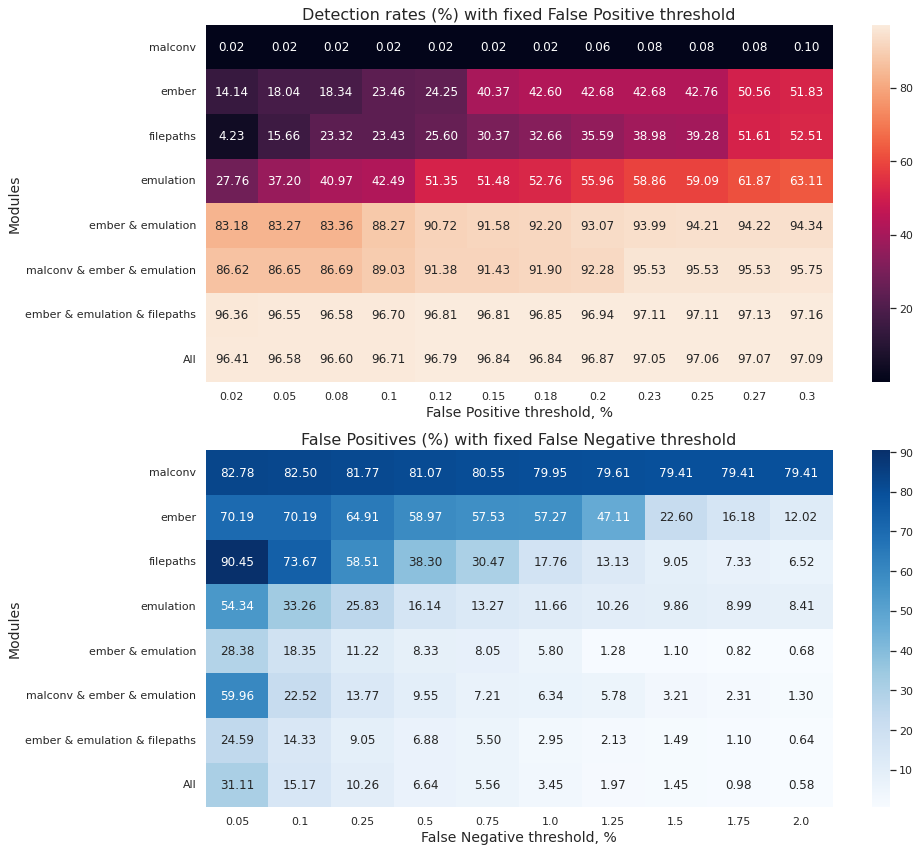

In [53]:
fig, ax = plt.subplots(2,1, figsize=(14,12))

_ = sns.heatmap(tpr_rates_fn, ax = ax[1],
            annot=True, fmt=".2f",
            xticklabels=fnr_rates,
            yticklabels=keys,
            cmap="Blues")

ax[1].set_xlabel("False Negative threshold, %", fontsize=14)
ax[1].set_ylabel("Modules", fontsize=14)
_ = ax[1].set_title("False Positives (%) with fixed False Negative threshold", fontsize=16)

_ = sns.heatmap(tpr_rates, ax = ax[0],
            annot=True, fmt=".2f",
            xticklabels=fpr_rates,
            yticklabels=keys)

ax[0].set_xlabel("False Positive threshold, %", fontsize=14)
ax[0].set_ylabel("Modules", fontsize=14)
_ = ax[0].set_title("Detection rates (%) with fixed False Positive threshold", fontsize=16)

fig.tight_layout()